## Exponentail Smoothing

* Double Exponential Smoothing
1. Additive Trend: Double Exponential Smoothing with a linear trend.
Additive Dampening: Dampen a trend linearly.
2. Multiplicative Trend: Double Exponential Smoothing with an exponential trend.
Multiplicative Dampening: Dampen the trend exponentially.

* Triple Exponential Smoothing
1. Additive Seasonality: Triple Exponential Smoothing with a linear seasonality.
2. Multiplicative Seasonality: Triple Exponential Smoothing with an exponential seasonality.
    
* smoothing_level (alpha): Smoothing factor for the level.
* smoothing_slope (beta): Smoothing factor for the trend.
* smoothing_seasonal (gamma): the smoothing coefficient for the seasonal component.
* Trend Type: Additive or multiplicative.
* Dampen Type: Additive or multiplicative.
* damping_slope (phi): the coefficient for the damped trend.
* Seasonality Type: Additive or multiplicative.
* Period: Time steps in seasonal period.
* use_boxcox: Whether or not to perform a power transform of the series (True/False) or specify the lambda for the transform.

In [167]:
#basic
import pandas as pd
import numpy as np

#plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data 
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

#modeling
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from math import sqrt
from sklearn.metrics import mean_squared_error

## Load Data

In [102]:
df = DataReader('LUV', data_source='yahoo', start='2021-3-01', end='2021-9-10')

In [103]:
df = df.resample("D").sum()

In [104]:
data = df.filter(['Close'])

In [105]:
training_data_len = int(np.ceil( len(data) * .9 ))
train = data[0:int(training_data_len)]
test = data[int(training_data_len):]

In [106]:
training_data_len

175

In [107]:
train.shape

(175, 1)

In [108]:
test.shape

(19, 1)

## Simple Exponential Smoothing

* No seasonality or trend.

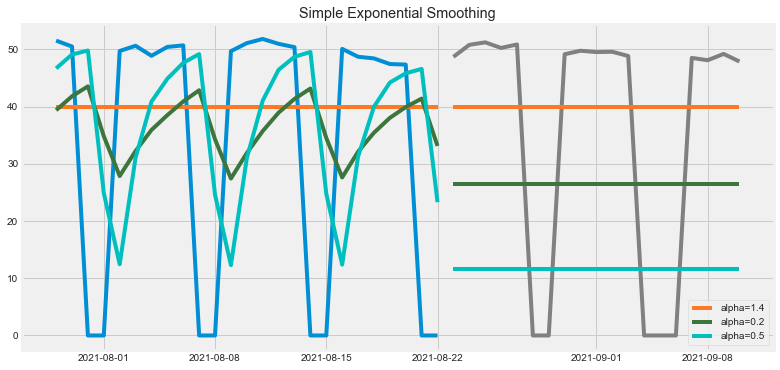

In [109]:
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()

model = SimpleExpSmoothing(np.asarray(train['Close']))
model._index = pd.to_datetime(train.index)

fit1 = model.fit()
pred1 = fit1.forecast(19)

fit2 = model.fit(smoothing_level=.2)
pred2 = fit2.forecast(19)

fit3 = model.fit(smoothing_level=.5)
pred3 = fit3.forecast(19)

fig, ax= plt.subplots(figsize=(12, 6))
ax.plot(train.index[150:], train.values[150:])
ax.plot(test.index, test.values, color="gray")

for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title("Simple Exponential Smoothing")    
plt.legend();


In [110]:
mse1 = ((pred1 - test['Close']) ** 2).mean()
mse1

487.0852327131446

In [111]:
mse2 = ((pred2 - test['Close']) ** 2).mean()
mse2

574.3957065721402

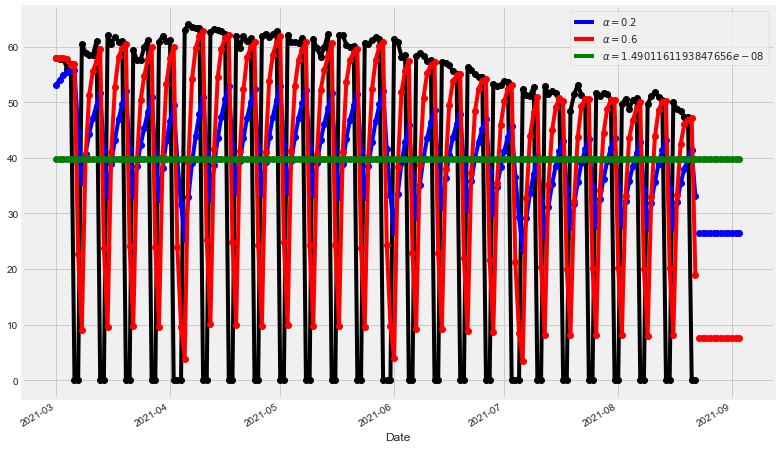

In [112]:
plt.figure(figsize=(12, 8))
plt.plot(train, marker="o", color="black")

fit1 = SimpleExpSmoothing(train ,initialization_method="heuristic").fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.2$')
# plot
fcast1.plot(marker='o', color='blue', legend=True)
fit1.fittedvalues.plot(marker='o',  color='blue')


fit2 = SimpleExpSmoothing(train).fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(12).rename(r'$\alpha=0.6$')
# plot
fcast2.plot(marker='o', color='red', legend=True)
fit2.fittedvalues.plot(marker='o', color='red')


fit3 = SimpleExpSmoothing(train).fit()
fcast3 = fit3.forecast(12).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
# plot
fcast3.plot(marker='o', color='green', legend=True)
fit3.fittedvalues.plot(marker='o', color='green')

plt.show()

### Holt’s

* Trend in data, No seasonality.
* Data has a trend. Use the multiplicative version, unless the data has been logged before. In this case, use the additive version

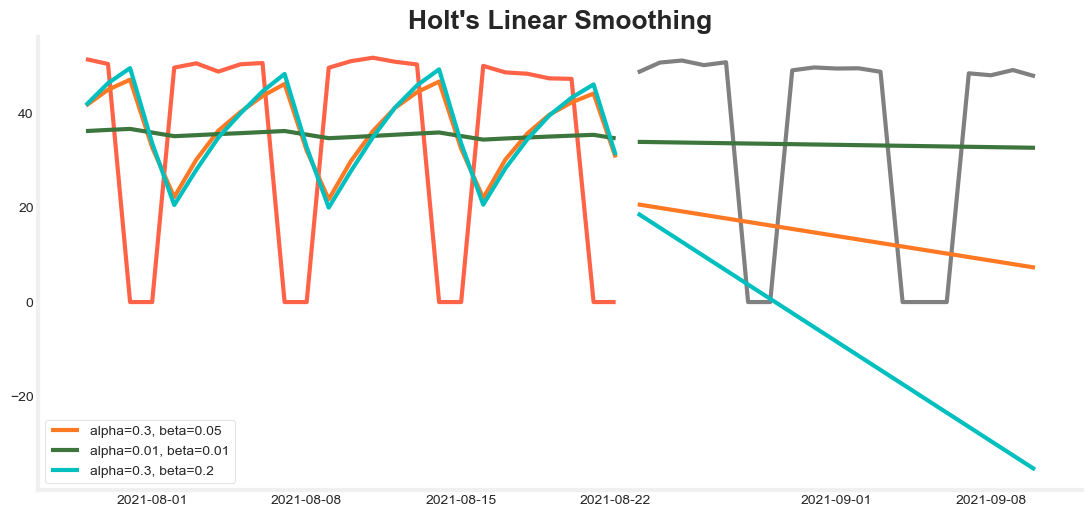

In [156]:
#Holt's linear smoothing
model = Holt(np.asarray(train['Close']))
model._index = pd.to_datetime(train.index)

fit1 = model.fit(smoothing_level=.3, smoothing_trend=.05)
pred1 = fit1.forecast(19)

fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(19)

fit3 = model.fit(smoothing_level=.3, smoothing_trend=.2)
pred3 = fit3.forecast(19)

with plt.style.context('images/presentation.mplstyle'):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(train.index[150:], train.values[150:])
    ax.plot(test.index, test.values, color="gray")
    for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
        ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
        ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4], color=c)
    plt.title("Holt's Linear Smoothing")
    plt.legend();

#plt.savefig('images/exsmoothing.png')

In [114]:
fit1.summary()

Dep. Variable:,endog,No. Observations:,175
Model:,Holt,SSE,156503.043
Optimized:,True,AIC,1197.308
Trend:,Additive,BIC,1209.967
Seasonal:,None,AICC,1197.808
Seasonal Periods:,None,Date:,"Mon, 13 Sep 2021"
Box-Cox:,False,Time:,10:25:33
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3000000,alpha,False
smoothing_trend,0.0500000,beta,False


In [176]:
fit2.summary()

Dep. Variable:,Close,No. Observations:,175
Model:,Holt,SSE,184772.273
Optimized:,True,AIC,1228.366
Trend:,Additive,BIC,1244.190
Seasonal:,None,AICC,1229.037
Seasonal Periods:,None,Date:,"Mon, 13 Sep 2021"
Box-Cox:,False,Time:,20:37:18
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8000000,alpha,False
smoothing_trend,0.2000000,beta,False


### Holt’s Damped Trend

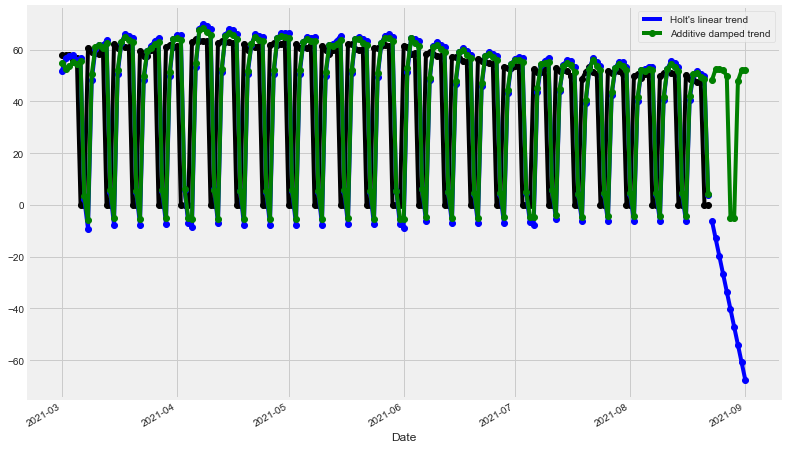

In [191]:
fit1 = Holt(train, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
fcast1 = fit1.forecast(10).rename("Holt's linear trend")

fit2 = Holt(train, damped_trend=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2
)
fcast2 = fit3.forecast(10).rename("Additive damped trend")

plt.figure(figsize=(12, 8))
plt.plot(train, marker="o", color="black")
fit1.fittedvalues.plot(marker="o", color='blue')
fcast1.plot(color='blue', marker="o", legend=True)

fit2.fittedvalues.plot(marker="o", color='green')
fcast2.plot(color='green', marker="o", legend=True)

plt.show()

In [193]:
display(fit1.sse, fit2.sse)

197303.20644518116

184772.27319959

In [117]:
fit1 = SimpleExpSmoothing(train, initialization_method="estimated").fit()
fcast1 = fit1.forecast(12).rename("SES")
fit2 = Holt(train, initialization_method="estimated").fit()
fcast2 = fit2.forecast(12).rename("Holt's")
#fit3 = Holt(train, exponential=True, initialization_method="estimated").fit()
#fcast3 = fit3.forecast(12).rename("Exponential")
fit4 = Holt(train, damped_trend=True, initialization_method="estimated").fit(
    damping_trend=0.98
)
fcast4 = fit4.forecast(12).rename("Additive Damped")
#fit5 = Holt(train, exponential=True, damped_trend=True, initialization_method="estimated").fit()
#fcast5 = fit5.forecast(12).rename("Multiplicative Damped")
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "initial_level",
    "initial_trend",
]
results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$l_0$", "$b_0$", "SSE"],
    columns=["SES", "Holt's", "Exponential", "Additive", "Multiplicative"],
)
results["SES"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Holt's"] = [fit2.params[p] for p in params] + [fit2.sse]
#results["Exponential"] = [fit3.params[p] for p in params] + [fit3.sse]
results["Additive"] = [fit4.params[p] for p in params] + [fit4.sse]
#results["Multiplicative"] = [fit5.params[p] for p in params] + [fit5.sse]
results

,SES,Holt's,Exponential,Additive,Multiplicative
$\alpha$,0.000066,0.078458,NaN,0.052133,NaN
$\beta$,NaN,0.069820,NaN,0.052133,NaN
$\phi$,NaN,NaN,NaN,0.980000,NaN
$l_0$,39.874574,42.232584,NaN,53.110411,NaN
$b_0$,NaN,-0.098362,NaN,-0.352471,NaN
SSE,123618.754414,132402.213480,NaN,128889.989975,NaN


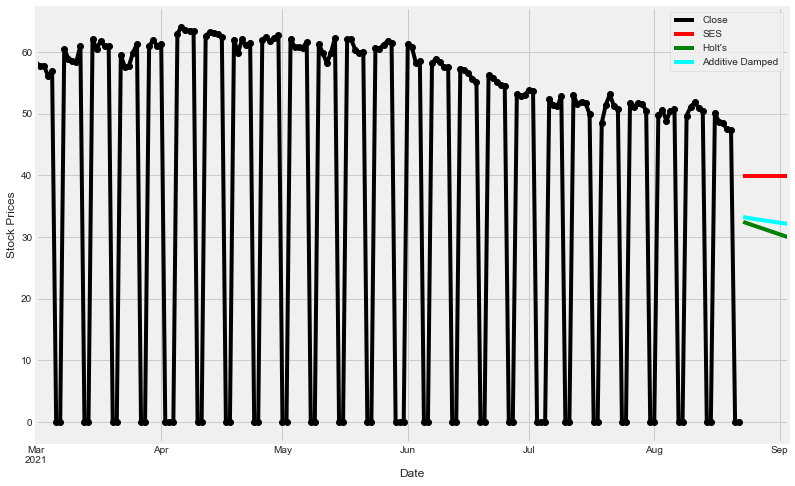

comparing forecasting performance of non-seasonal methods.


In [118]:
ax = train.plot(color="black", marker="o", figsize=(12, 8))
fcast1.plot(ax=ax, color="red", legend=True)
fcast2.plot(ax=ax, color="green", legend=True)
#fcast3.plot(ax=ax, color="blue", legend=True)
fcast4.plot(ax=ax, color="cyan", legend=True)
#fcast5.plot(ax=ax, color="magenta", legend=True)
ax.set_ylabel("Stock Prices")
plt.show()
print(
    "comparing forecasting performance of non-seasonal methods."
)

### Holt-Winter’s Seasonal Smoothing model

* Additive method: the seasonal variations are roughly constant throughout the series.
* Multiplicative method: the seasonal variations are changing proportionally to the level of the series.

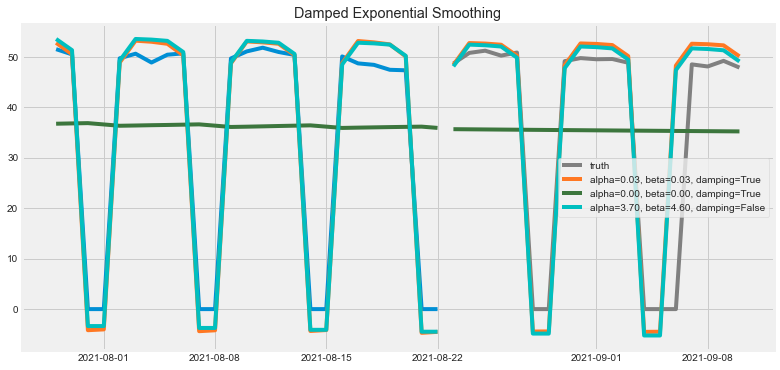

In [185]:
model = ExponentialSmoothing((train['Close']), trend='add', seasonal='add',damped=True)
model2 = ExponentialSmoothing(train['Close'], trend='add', seasonal=None, damped=True)
model3 = ExponentialSmoothing(train['Close'], trend='add', seasonal='add', damped=False)
model._index = pd.to_datetime(train.index)

fit1 = model.fit()
fit2 = model2.fit()
fit3 = model3.fit()
pred1 = fit1.forecast(19)
pred2 = fit2.forecast(19)
pred3 = fit3.forecast(19)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[150:], train.values[150:])
ax.plot(test.index, test.values, color="gray", label="truth")

for p, f, c in zip((pred1, pred2,pred3),(fit1, fit2,fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4]+ ", damping="+str(True if f.params['damping_trend']>0 else False), color=c)
   
ax.set_title("Damped Exponential Smoothing");
plt.legend();

In [190]:
sse1 = np.sqrt(np.mean(np.square(test.values - pred1.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - pred2.values)))
sse3 = np.sqrt(np.mean(np.square(test.values - pred3.values)))

display(sse1,sse2, sse3)

31.667102069894266

22.133219411660047

31.594226707052755

### Including seasonal period

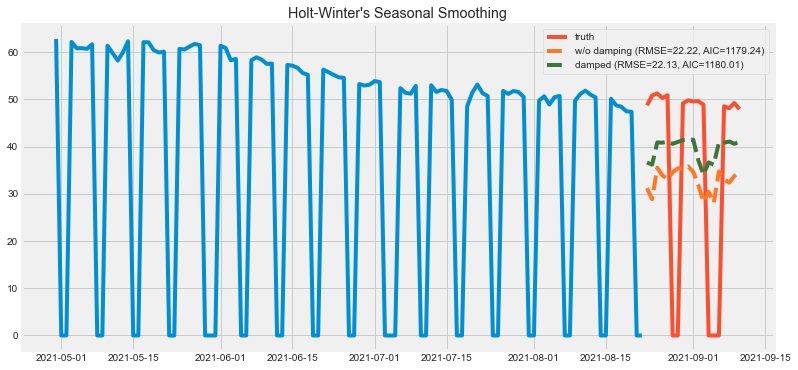

In [186]:

model1= ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12)
model2 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12, damped=True)
fit1 = model1.fit()
pred = fit.forecast(19)
fit2 = model2.fit()
pred2 = fit2.forecast(19)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[60:], train.values[60:]);
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, pred, linestyle='--', color='#ff7823', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.plot(test.index, pred2, linestyle='--', color='#3c763d', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

In [189]:
sse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - pred2.values)))
display(sse1 , sse2)

22.222167364798885

22.133219411660047

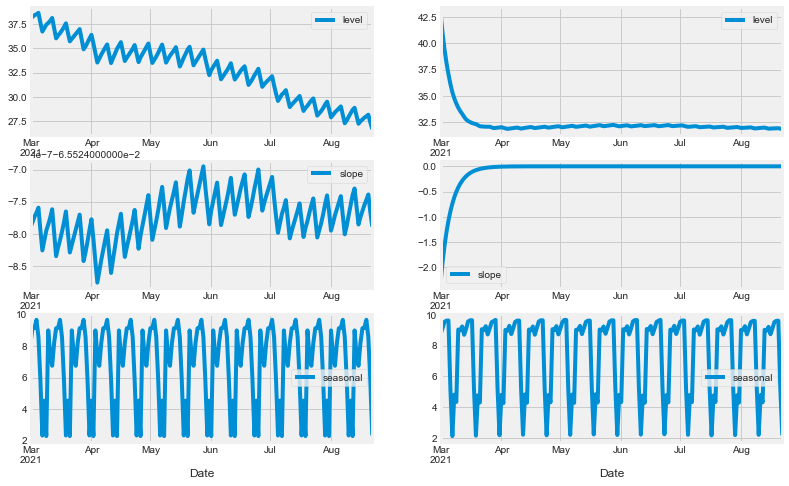

In [155]:
states1 = pd.DataFrame(
    np.c_[fit1.level, fit1.trend, fit1.season],
    columns=["level", "slope", "seasonal"],
    index=train.index,
)
states2 = pd.DataFrame(
    np.c_[fit2.level, fit2.trend, fit2.season],
    columns=["level", "slope", "seasonal"],
    index=train.index,
)
fig, [[ax1, ax4], [ax2, ax5], [ax3, ax6]] = plt.subplots(3, 2, figsize=(12, 8))
states1[["level"]].plot(ax=ax1)
states1[["slope"]].plot(ax=ax2)
states1[["seasonal"]].plot(ax=ax3)
states2[["level"]].plot(ax=ax4)
states2[["slope"]].plot(ax=ax5)
states2[["seasonal"]].plot(ax=ax6)
plt.show()

### Manual Grid Search comparing RMSE

In [136]:
df = DataReader('AAL', data_source='yahoo', start='2020-03-01', end='2021-9-10')

In [137]:
data = df.filter(['Close'])

In [138]:
dataset = data.values

In [139]:
training_data_len = int(np.ceil( len(dataset) * .9 ))

In [140]:
# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model
    history = np.array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

In [142]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
 

In [143]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [144]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error
 

In [145]:
#Trend:
t= 'mul'
#Damped: 
d= False
#Seasonal: 
s= None
#Seasonal Periods: 
p= None
#Box-Cox Transform: 
b= True
#Remove Bias: 
r= True

cfg = t,d,s,p,b,r 

#t_params = ['add', 'mul', None]
#d_params = [True, False]
#s_params = ['add', 'mul', None]
#p_params = seasonal
#b_params = [True, False]
#r_params = [True, False]


In [146]:
walk_forward_validation(dataset, training_data_len , cfg)

0.7032213755346893

In [147]:
#Trend:
t= 'mul'
#Damped: 
d= False
#Seasonal: 
s= None
#Seasonal Periods: 
p= None
#Box-Cox Transform: 
b= False
#Remove Bias: 
r= False

cfg_trend = t,d,s,p,b,r 

walk_forward_validation(dataset, training_data_len , cfg_trend )

0.7098023201792961

In [96]:
#Trend:
t= None
#Damped: 
d= False
#Seasonal: 
s= 'add'
#Seasonal Periods: 
p= 12
#Box-Cox Transform: 
b= False
#Remove Bias: 
r= False

cfg_sea = t,d,s,p,b,r 

walk_forward_validation(dataset, training_data_len , cfg_sea )

0.7800449183821221

In [148]:
#Trend:
t= None
#Damped: 
d= False
#Seasonal: 
s= 'add'
#Seasonal Periods: 
p= 12
#Box-Cox Transform: 
b= False
#Remove Bias: 
r= True

cfg_sea2 = t,d,s,p,b,r 

walk_forward_validation(dataset, training_data_len ,cfg_sea2)

0.7864258592597647

In [98]:
#Trend:
t= 'add'
#Damped: 
d= False
#Seasonal: 
s= 'add'
#Seasonal Periods: 
p= 12
#Box-Cox Transform: 
b= False
#Remove Bias: 
r= False 


cfg_both = t,d,s,p,b,r 

walk_forward_validation(dataset, training_data_len ,cfg_both)

0.7954844509350766

In [149]:
#Trend:
t= 'add'
#Damped: 
d= True 
#Seasonal: 
s= 'add'
#Seasonal Periods: 
p= 12
#Box-Cox Transform: 
b= False
#Remove Bias: 
r= False 


cfg_both2 = t,d,s,p,b,r 

walk_forward_validation(dataset, training_data_len ,cfg_both2)

0.7870885091750273